In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [ transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2
                                         )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2
                                        )

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

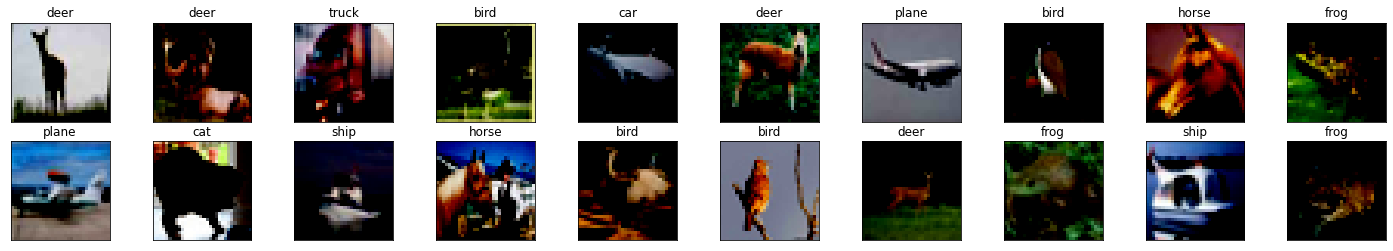

In [7]:
import matplotlib.pyplot as plt
import numpy as np
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [103]:
class Custom_Batchnorm2d(nn.BatchNorm2d):
  def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
    super(Custom_Batchnorm2d, self).__init__(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  def forward(self, x):
    self._check_input_dim(x)
    momentum = self.momentum
    if self.training:
      mean = torch.mean(x, dim=(0,2,3))
      var = torch.var(x, dim=(0, 2, 3), unbiased=False)
      m = x.numel()/x.size(1)
      
      with torch.no_grad():
        self.running_mean = momentum * mean + (1 - momentum) * self.running_mean
        self.running_var = momentum * var * m / (m-1) + (1 - momentum) * self.running_var
    else:
      mean = self.running_mean
      var = self.running_var

    x =  (x - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
    if self.affine:
      x = x * self.weight[None,:,None,None] + self.bias[None,:,None,None]
    
    return x

In [104]:
x = torch.randn(2,3,4,4) * 8 + 3
my_bn = Custom_Batchnorm2d(3, affine=True)
torch_bn = nn.BatchNorm2d(3, affine=True)
out1 = my_bn(x)
out2 = torch_bn(x)
print('Max diff: ', (out1 - out2).abs().max().item())

Max diff:  4.76837158203125e-07


In [105]:
class LeNet_custom_batch(nn.Module):
    def __init__(self):
        super(LeNet_custom_batch, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batchnorm1=Custom_Batchnorm2d(6)
        self.pool1=nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batchnorm2=Custom_Batchnorm2d(16)
        self.pool2=nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [106]:
model = LeNet_custom_batch()
print(model)

LeNet_custom_batch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): Custom_Batchnorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): Custom_Batchnorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [117]:
model.to(device)

LeNet_custom_batch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): Custom_Batchnorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): Custom_Batchnorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [118]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
train_losses=[]
for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(images)
        # calculate the loss
        loss = criterion(output,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    train_losses.append(train_loss)
     
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch+1, 
          train_loss
          ))

Epoch: 1 	Training Loss: 1.483748
Epoch: 2 	Training Loss: 1.264234
Epoch: 3 	Training Loss: 1.131928
Epoch: 4 	Training Loss: 1.045437
Epoch: 5 	Training Loss: 0.977101
Epoch: 6 	Training Loss: 0.923107
Epoch: 7 	Training Loss: 0.878291
Epoch: 8 	Training Loss: 0.833870
Epoch: 9 	Training Loss: 0.801249
Epoch: 10 	Training Loss: 0.766701


In [132]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1= nn.BatchNorm2d(6)
        self.pool1=nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2= nn.BatchNorm2d(16)
        self.pool2=nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [133]:
model1 = LeNet()
print(model1)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [134]:
model1.to(device)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [136]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
train_losses1=[]
for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1.forward(images)
        # calculate the loss
        loss = criterion(output,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    train_losses1.append(train_loss) 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch+1, 
          train_loss
          ))

Epoch: 1 	Training Loss: 1.509840
Epoch: 2 	Training Loss: 1.246700
Epoch: 3 	Training Loss: 1.131935
Epoch: 4 	Training Loss: 1.057210
Epoch: 5 	Training Loss: 0.999496
Epoch: 6 	Training Loss: 0.953732
Epoch: 7 	Training Loss: 0.906133
Epoch: 8 	Training Loss: 0.869005
Epoch: 9 	Training Loss: 0.831942
Epoch: 10 	Training Loss: 0.800527


Text(0, 0.5, 'Loss')

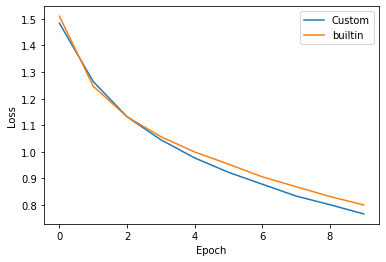

In [144]:
plt.plot(train_losses, label='Custom')
plt.plot(train_losses1, label='builtin')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [140]:
correct1, correct2 = 0, 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    output1 = model(images)
    output2 = model1(images)
    
    _, predicted = torch.max(output1.data, 1)
    _, predicted2 = torch.max(output2.data, 1)
    
    total += labels.size(0)
    
    correct1 += (predicted == labels).sum().item()
    correct2 += (predicted2 == labels).sum().item()
    
print("Accuracy of the network using my batch norm: %2.3f %%" % (100 * correct1 / total))
print("Accuracy of the network using pytorch's built-in batch norm: %2.3f %%" % (100 * correct2 / total))
print("Diff: %.3f" % ((100 * correct1 / total) - (100 * correct2 / total)))

Accuracy of the network using my batch norm: 56.170 %
Accuracy of the network using pytorch's built-in batch norm: 64.310 %
Diff: -8.140
